In [1]:
import poppler

In [2]:
doc = poppler.load_from_file("/data/Basic Rules (2014).pdf")

In [3]:
doc.infos()

{'Title': 'Basic Rules (2014)',
 'Creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
 'Producer': 'Skia/PDF m131',
 'CreationDate': datetime.datetime(2024, 12, 29, 19, 22, 27),
 'ModDate': datetime.datetime(2024, 12, 29, 19, 22, 27)}

In [4]:
font_iterator = doc.create_font_iterator()
for page, fonts in font_iterator:
    print(f"Fonts for page {page}")
    for font in fonts:
        print(f"- {font.name}")

Fonts for page 0
- AAAAAA+Roboto-Bold
- BAAAAA+ArialMT
Fonts for page 1
Fonts for page 2
- CAAAAA+Roboto-Regular
Fonts for page 3
Fonts for page 4
Fonts for page 5
Fonts for page 6
Fonts for page 7
Fonts for page 8
Fonts for page 9
Fonts for page 10
Fonts for page 11
Fonts for page 12
Fonts for page 13
Fonts for page 14
- CAAAAA+Roboto-Regular
Fonts for page 15
Fonts for page 16
Fonts for page 17
Fonts for page 18
Fonts for page 19
Fonts for page 20
Fonts for page 21
Fonts for page 22
Fonts for page 23
- AAAAAA+Roboto-Bold
Fonts for page 24
Fonts for page 25
Fonts for page 26
Fonts for page 27
Fonts for page 28
Fonts for page 29
Fonts for page 30
Fonts for page 31
Fonts for page 32
- AAAAAA+Roboto-Bold
Fonts for page 33
Fonts for page 34
Fonts for page 35
Fonts for page 36
Fonts for page 37
Fonts for page 38
Fonts for page 39
Fonts for page 40
Fonts for page 41
Fonts for page 42
Fonts for page 43
Fonts for page 44
Fonts for page 45
Fonts for page 46
Fonts for page 47
Fonts for page 48


In [5]:
import pandas as pd

data = [
    (p, i, b.text, b.get_font_name(), b.get_font_size())
      for p in range(doc.pages)
      for i, b in enumerate(doc.create_page(p).text_list(doc.create_page(p).TextListOption.text_list_include_font))
]
df = pd.DataFrame(data, columns=["page", "word_in_page", "text", "font", "size"])
df

,page,word_in_page,text,font,size
0,0,0,"12/29/24,",BAAAAA+ArialMT,7.995000
1,0,1,12:22,BAAAAA+ArialMT,7.995000
2,0,2,PM,BAAAAA+ArialMT,7.995000
3,0,3,Basic,BAAAAA+ArialMT,7.995000
4,0,4,Rules,BAAAAA+ArialMT,7.995000
...,...,...,...,...,...
217858,571,273,of,CAAAAA+Roboto-Regular,9.723755
217859,571,274,the,CAAAAA+Roboto-Regular,9.723755
217860,571,275,demiplane.,CAAAAA+Roboto-Regular,9.723755
217861,571,276,https://www.dndbeyond.com/sources/dnd/basic-ru...,BAAAAA+ArialMT,7.995000


array([[<Axes: title={'center': 'size'}>]], dtype=object)

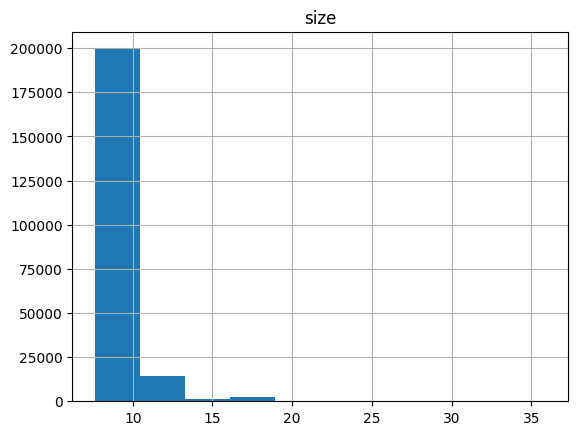

In [6]:
df.hist("size", bins=10)

In [7]:
df.groupby("size")["size"].unique()

size
7.625171      [7.625171473128263]
7.995000      [7.994999516875009]
8.211723      [8.211723124907358]
8.464450       [8.46445045308004]
9.384826      [9.384826428465553]
9.723755      [9.723755402843508]
10.023018    [10.023017650898549]
10.471737    [10.471736587677624]
10.557930    [10.557929732023748]
10.794019    [10.794019008659973]
13.463661    [13.463661327014089]
14.959624    [14.959623696682321]
15.707605    [15.707604881516437]
17.801951    [17.801951451070778]
18.349832      [18.3498315437206]
20.943473    [20.943473175355248]
31.415210    [31.415209763032873]
35.903097    [35.903096872037565]
Name: size, dtype: object

In [8]:
chapter_headers = df.query("size > 30 and size < 35")
section_headers = df.query("size > 20 and size < 30")
section_headers

,page,word_in_page,text,font,size
1148,6,418,Worlds,AAAAAA+Roboto-Bold,20.943473
1149,6,419,of,AAAAAA+Roboto-Bold,20.943473
1150,6,420,Adventure,AAAAAA+Roboto-Bold,20.943473
1510,6,780,Using,AAAAAA+Roboto-Bold,20.943473
1511,6,781,These,AAAAAA+Roboto-Bold,20.943473
...,...,...,...,...,...
216422,569,142,Material,AAAAAA+Roboto-Bold,20.943473
216423,569,143,Plane,AAAAAA+Roboto-Bold,20.943473
216550,569,270,Beyond,AAAAAA+Roboto-Bold,20.943473
216551,569,271,the,AAAAAA+Roboto-Bold,20.943473


In [9]:
df.query("size > 15 and size < 20")

,page,word_in_page,text,font,size
25,2,6,Introduction,AAAAAA+Roboto-Bold,17.801951
26,2,7,Part,AAAAAA+Roboto-Bold,17.801951
27,2,8,1:,AAAAAA+Roboto-Bold,17.801951
28,2,9,Creating,AAAAAA+Roboto-Bold,17.801951
29,2,10,A,AAAAAA+Roboto-Bold,17.801951
...,...,...,...,...,...
216894,570,7,Planes,AAAAAA+Roboto-Bold,17.801951
217134,570,247,Inner,AAAAAA+Roboto-Bold,17.801951
217135,570,248,Planes,AAAAAA+Roboto-Bold,17.801951
217311,570,424,Outer,AAAAAA+Roboto-Bold,17.801951


In [10]:
section_headers.groupby("page")["text"].apply(lambda x: " ".join(x))

page
6       Worlds of Adventure Using These Rules
7                                 How to Play
9                                  Adventures
10                       The Wonders of Magic
13         1. Choose a Race 2. Choose a Class
                        ...                  
564                     Order of the Gauntlet
565                           Emerald Enclave
566                           Lords' Alliance
567                                 Zhentarim
569    The Material Plane Beyond the Material
Name: text, Length: 142, dtype: object

In [11]:
section_starts = section_headers.groupby("page")[["page", "word_in_page"]].transform(lambda x: min(x)).drop_duplicates()

In [12]:
chapter_headers.groupby("page")["text"].transform(lambda x: " ".join(x)).drop_duplicates()

361                                 Introduction
4268         Chapter 1: Step- By-Step Characters
8459                            Chapter 2: Races
21425                         Chapter 3: Classes
57909      Chapter 4: Personality and Background
66262                       Chapter 5: Equipment
77600           Chapter 6: Customization Options
79468            Chapter 7: Using Ability Scores
84771                     Chapter 8: Adventuring
90390                          Chapter 9: Combat
98235                   Chapter 10: Spellcasting
101971                        Chapter 11: Spells
157593                      Chapter 12: Monsters
166741    Chapter 13: Building Combat Encounters
168593                   Chapter 14: Magic Items
204380              Chapter 15: Running the Game
210895                    Appendix A: Conditions
211827        Appendix B: Gods of the Multiverse
214306             Appendix C: The Five Factions
216286       Appendix D: The Planes of Existence
Name: text, dtype: o

In [13]:
for pg, fonts in doc.create_font_iterator():
    print(pg, [f.name for f in fonts])

0 ['AAAAAA+Roboto-Bold', 'BAAAAA+ArialMT']
1 []
2 ['CAAAAA+Roboto-Regular']
3 []
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 []
12 []
13 []
14 ['CAAAAA+Roboto-Regular']
15 []
16 []
17 []
18 []
19 []
20 []
21 []
22 []
23 ['AAAAAA+Roboto-Bold']
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 ['AAAAAA+Roboto-Bold']
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 ['']
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70 []
71 []
72 []
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 ['AAAAAA+Roboto-Bold']
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 []
100 []
101 []
102 []
103 []
104 []
105 []
106 []
107 []
108 []
109 []
110 []
111 []
112 []
113 []
114 []
115 []
116 []
117 []
118 []
119 []
120 []
121 []
122 []
123 []
124 []
125 []
126 []
127 []
128 []
129 []
130 []
131 []
132 ['AAAAAA+Roboto-Bold']
133 ['']
134 

In [14]:
chapter_starts = chapter_headers.groupby("page")[["page", "word_in_page"]].transform(lambda x: min(x)).drop_duplicates()
chapter_starts

,page,word_in_page
361,5,6
4268,11,6
8459,25,6
21425,59,6
57909,145,6
66262,169,6
77600,200,6
79468,205,6
84771,219,6
90390,231,6


In [15]:
chapter_heading = []
section_heading = []
subsection_heading = []
current_doc = []

last_font_size = 0

docs = {}
def stringify(thing):
    return " ".join(thing)

for p in range(doc.pages):
    page = doc.create_page(p)
    for b in page.text_list(page.TextListOption.text_list_include_font):
        font_size = b.get_font_size()

        if font_size < last_font_size:
            current_doc.append("\n--------\n")

        if font_size < 20:
            if font_size > last_font_size:
                current_doc.append("\n")
            current_doc.append(b.text)

        if font_size > last_font_size:
            if font_size > 20:
                # end of section
                docs[f"{stringify(chapter_heading)}{(' - ' + stringify(section_heading)) if section_heading else ''}"] = f"{stringify(chapter_heading)}\n\n{stringify(section_heading)}\n{stringify(current_doc)}"
                current_doc = []
                section_heading = []
                if font_size > 30:
                    # end of chapter
                    chapter_heading = []
            elif font_size > 18:
                # end of sub-subsection
                docs[f"{stringify(chapter_heading)} - {stringify(section_heading)} - {stringify(subsection_heading)}"] = f"{stringify(chapter_heading)}\n\n{stringify(section_heading)}\n{stringify(subsection_heading)}\n{stringify(current_doc)}"
                current_doc = []
                subsection_heading = []            

        if font_size > 30 and font_size < 35:
            chapter_heading.append(b.text)

        if font_size > 20 and font_size < 30:
            section_heading.append(b.text)
        elif font_size > 18 and font_size < 20:
            subsection_heading.append(b.text)

        last_font_size = font_size
docs

{'': "\n\n\n\n--------\n https://www.dndbeyond.com/sources/dnd/basic-rules-2014 1/572 12/29/24, 12:22 PM https://www.dndbeyond.com/sources/dnd/basic-rules-2014 Basic Rules (2014) 2/572 12/29/24, 12:22 PM Basic Rules (2014) \n Introduction Part 1: Creating A Character \n--------\n Ch. 1: Step-By-Step Characters \n--------\n 1. Choose a Race 2. Choose a Class 3. Determine Ability Scores 4. Describe Your Character 5. Choose Equipment 6. Come Together Beyond 1st Level \n Ch. 2: Races \n--------\n Choosing a Race Racial Traits Dwarf | Elf | Halfling | Human | Dragonborn | Gnome | Half-Elf | Half-Orc | Tiefling \n Ch. 3: Classes \n--------\n Classes Summary Barbarian | Bard | Cleric | Druid | Fighter | Monk | Paladin | Ranger | Rogue | Sorcerer | Warlock | Wizard \n Ch. 4: Personality and Background \n--------\n Character Details Personal Characteristics Inspiration Backgrounds \n Ch. 5: Equipment \n--------\n Starting Equipment and Wealth Armor and Shields Weapons Adventuring Gear Tools Exp

In [20]:
from utils.elastic import elastic_request
import requests
test = elastic_request(method=requests.post, url="_ingest/pipeline/clean_and_embed/_simulate", data={"docs":[{"_source": {"content": docs["Chapter 1: Step- By-Step Characters"]}}]})
test.json()

/workspaces/llm-dungeon-master/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


{'docs': [{'doc': {'_index': '_index',
    '_version': '-3',
    '_id': '_id',
    '_source': {'content-embedding': [0.02781081013381481,
      0.04686406999826431,
      0.02773638442158699,
      0.005448661278933287,
      -0.003485654713585973,
      -0.04195190221071243,
      0.036221038550138474,
      0.01304949726909399,
      0.0033709134440869093,
      0.07244207710027695,
      -0.004629966802895069,
      -0.022067543119192123,
      0.010835300199687481,
      -0.02855507843196392,
      0.050610218197107315,
      0.04043855518102646,
      -0.024846144020557404,
      -0.003795766271650791,
      0.01333479955792427,
      0.03369052708148956,
      0.040041614323854446,
      0.03659317269921303,
      0.0033895201049745083,
      0.03460845723748207,
      -0.02912568300962448,
      0.011920690536499023,
      0.01751510426402092,
      0.007144971750676632,
      0.0029600155539810658,
      -0.03577447682619095,
      0.015319514088332653,
      -0.020988354459404

In [18]:
from utils.elastic import elastic_request
def ingest(doc, title, index):
    cleaned_title = title.replace("?", "").replace("/", "-")
    rslt = elastic_request(method=requests.put,
                           url=f"{index}/_doc/{cleaned_title}?pipeline=clean_and_embed",
                           data={"content": doc})
    return rslt


In [22]:
for title, item in docs.items():
    if title:
        try:
            rslt = ingest(item, title, "basic-rules-2014")
            rslt.raise_for_status()
        except Exception as e:
            print("Error: ", e)
            print(rslt.json())
            raise

/workspaces/llm-dungeon-master/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/llm-dungeon-master/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/llm-dungeon-master/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/worksp

In [253]:
docs_to_ingest = []

for cursor in range(len(chapter_starts)):
    start = chapter_starts.iloc[cursor]
    print(df.query(f"page == {start.page} and word_in_page >= {start.word_in_page}")["text"].values[0])
    qry = f"page >= {start.page} and word_in_page > {start.word_in_page}"
    if cursor+1 < len(chapter_starts):
        end = chapter_starts.iloc[cursor+1]
        qry += f" and page <= {end.word_in_page} and word_in_page < {end.word_in_page}"

    sections_in_chapter = section_starts.query(qry)
    if sections_in_chapter.empty:
        docs_to_ingest.append(df.query(qry)["text"].transform(lambda x: " ".join(x)).values)
    for cursor2 in range(len(sections_in_chapter)):
        pass   


# each section (defined from start word of a header to start word of the next header)
#for cursor in range(len(section_starts)):
#    start = section_starts.iloc[cursor]
    #print(df.query(f"page == {start.page} and word_in_page == {start.word_in_page}")["text"].values[0])
#    if cursor+1 < len(section_starts):
#        end = section_starts.iloc[cursor+1]
    #    print(cursor, start.page, start.word_in_page, '-->', end.page, end.word_in_page)
    #else:
    #    print(cursor, start.page, start.word_in_page, '-->', "END")
    
    # get contents of section
    # prepend header for chapter the section is in
    
# for each section header in the chapter (we know because it appears on a page between chapter N and chapter N+1)
# create a doc containing everything between the section header and the next section header
docs_to_ingest

Introduction
Chapter
Chapter
Chapter
Chapter
Chapter
Chapter
Chapter
Chapter
Chapter
Chapter
Chapter
Chapter
Chapter
Chapter
Chapter
Appendix
Appendix
Appendix
Appendix


[array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object),
 array([], dtype=object)]